In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import patsy
import statsmodels.api as sm
from umap import UMAP 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, adjusted_rand_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


# suppresses annoying errors
import os
import sys

# Redirect stderr to /dev/null (Linux/macOS) or nul (Windows)
if os.name == 'posix':
    sys.stderr = open(os.devnull, 'w')
elif os.name == 'nt':
    sys.stderr = open('nul', 'w')


# Data Preprocessing

#### Reading in Dataset + First Look at Data

In [37]:
# reading in dataset
obesity=pd.read_csv('obesity.csv')
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [38]:
obesity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

We see above looking at the informational table that we do not have any null values in any of the columns in the dataset. If we did have missing values we would have to explore the missingness of those values and impute the missing data.

#### Cleaning Dataset

In [39]:
# renaming variable columns 

obesity.rename(columns={'family_history_with_overweight': 'Family Obesity', 
                        'FAVC': 'High Calories', 
                        'FCVC': 'Vegetables', 
                        'NCP': 'Meals',
                        'CAEC': 'Food Between Meals',
                        'SMOKE': 'Smoke',
                        'CH2O': 'Water',
                        'SCC': 'Monitor Calories',
                        'FAF': 'Excercise',
                        'TUE': 'Technology',
                        'CALC': 'Alcohol',
                        'MTRANS': 'Transportation Movement'
                        }, inplace=True)

obesity.head()

,Gender,Age,Height,Weight,Family Obesity,High Calories,Vegetables,Meals,Food Between Meals,Smoke,Water,Monitor Calories,Excercise,Technology,Alcohol,Transportation Movement,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


#### Variables

- `Gender`: categorical (male, female)
- `Age`: discrete numerical
- `Height`: continuous numerical
- `Weight`: continous numerical
- `Family Obesity`: categorical (History of Family Obesity)
- `High Calories`: categorical (Frequent High Calorie Consumption)
- `Vegetables`: continuous (Frequency of Vegetable Consumption)
- `Meals`: continous (Daily Meal Count)

In [43]:
# clean vegetables column
obesity['Meals'].value_counts()

Meals
3.000000    1203
1.000000     199
4.000000      69
2.776840       2
3.985442       2
            ... 
3.054899       1
3.118013       1
3.335876       1
3.205009       1
1.089048       1
Name: count, Length: 635, dtype: int64

In [28]:
obesity.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'Family_Obesity', 'High_Calories',
       'Vegetables', 'Meals', 'Food_Between_Meals', 'Smoke', 'Water',
       'Monitor_Calories', 'Excercise', 'Technology', 'Alcohol',
       'Transportation_Movement', 'NObeyesdad'],
      dtype='object')

In [22]:
categorical_mapping = {'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3 }
obesity['Alcohol'] = obesity['Alcohol'].map(categorical_mapping)
obesity['Food_Between_Meals'] = obesity['Food_Between_Meals'].map(categorical_mapping)

numerical_columns = ['Age', 'Height', 'Weight', 'Vegetables', 'Meals', 'Food_Between_Meals', 'Water', 'Excercise', 'Technology', 'Alcohol']
scaler = StandardScaler()
obesity[numerical_columns] = scaler.fit_transform(obesity[numerical_columns])

obesity.head()

,Gender,Age,Height,Weight,Family_Obesity,High_Calories,Vegetables,Meals,Food_Between_Meals,Smoke,Water,Monitor_Calories,Excercise,Technology,Alcohol,Transportation_Movement,NObeyesdad
0,Female,-0.522124,-0.875589,-0.862558,yes,no,-0.785019,0.404153,-0.300346,no,-0.013073,no,-1.188039,0.561997,-1.419172,Public_Transportation,Normal_Weight
1,Female,-0.522124,-1.947599,-1.168077,yes,no,1.088342,0.404153,-0.300346,yes,1.618759,yes,2.339750,-1.080625,0.521160,Public_Transportation,Normal_Weight
2,Male,-0.206889,1.054029,-0.366090,yes,no,-0.785019,0.404153,-0.300346,no,-0.013073,no,1.163820,0.561997,2.461491,Public_Transportation,Normal_Weight
3,Male,0.423582,1.054029,0.015808,no,no,1.088342,0.404153,-0.300346,no,-0.013073,no,1.163820,-1.080625,2.461491,Walking,Overweight_Level_I
4,Male,-0.364507,0.839627,0.122740,no,no,-0.785019,-2.167023,-0.300346,no,-0.013073,no,-1.188039,-1.080625,0.521160,Public_Transportation,Overweight_Level_II


In [15]:
# Identify the categorical columns to be one-hot encoded
categorical_columns = ['Gender', 'Family_Obesity', 'High_Calories', 'Smoke', 'Monitor_Calories', 'Transportation_Movement']

# Perform one-hot encoding
obesity = pd.get_dummies(obesity, columns=categorical_columns)

# Display the encoded DataFrame
obesity.head()

,Age,Height,Weight,Vegetables,Meals,Food_Between_Meals,Water,Excercise,Technology,Alcohol,...,High_Calories_yes,Smoke_no,Smoke_yes,Monitor_Calories_no,Monitor_Calories_yes,Transportation_Movement_Automobile,Transportation_Movement_Bike,Transportation_Movement_Motorbike,Transportation_Movement_Public_Transportation,Transportation_Movement_Walking
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.300346,-0.013073,-1.188039,0.561997,-1.419172,...,False,True,False,True,False,False,False,False,True,False
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,-0.300346,1.618759,2.339750,-1.080625,0.521160,...,False,False,True,False,True,False,False,False,True,False
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.300346,-0.013073,1.163820,0.561997,2.461491,...,False,True,False,True,False,False,False,False,True,False
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.300346,-0.013073,1.163820,-1.080625,2.461491,...,False,True,False,True,False,False,False,False,False,True
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.300346,-0.013073,-1.188039,-1.080625,0.521160,...,False,True,False,True,False,False,False,False,True,False


In [8]:
obesity.head()

,Age,Height,Weight,Vegetables,Meals,Food_Between_Meals,Water,Excercise,Technology,Alcohol,...,High_Calories_yes,Smoke_no,Smoke_yes,Monitor_Calories_no,Monitor_Calories_yes,Transportation_Movement_Automobile,Transportation_Movement_Bike,Transportation_Movement_Motorbike,Transportation_Movement_Public_Transportation,Transportation_Movement_Walking
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.300346,-0.013073,-1.188039,0.561997,-1.419172,...,False,True,False,True,False,False,False,False,True,False
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,-0.300346,1.618759,2.339750,-1.080625,0.521160,...,False,False,True,False,True,False,False,False,True,False
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.300346,-0.013073,1.163820,0.561997,2.461491,...,False,True,False,True,False,False,False,False,True,False
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.300346,-0.013073,1.163820,-1.080625,2.461491,...,False,True,False,True,False,False,False,False,False,True
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.300346,-0.013073,-1.188039,-1.080625,0.521160,...,False,True,False,True,False,False,False,False,True,False


In [16]:
# obesity_labels = obesity.columns.tolist()
obesity_labels = obesity['NObeyesdad']
Cleaned_Data = obesity.drop('NObeyesdad', axis=1)
y = obesity['NObeyesdad']
print(obesity_labels)

0             Normal_Weight
1             Normal_Weight
2             Normal_Weight
3        Overweight_Level_I
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: NObeyesdad, Length: 2111, dtype: object


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X = Cleaned_Data
y = y
 
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)


In [13]:
#Preview of the labels
y

0             Normal_Weight
1             Normal_Weight
2             Normal_Weight
3        Overweight_Level_I
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: NObeyesdad, Length: 2111, dtype: object

In [14]:
# Preview of the training dataset
X_train

,Age,Height,Weight,Vegetables,Meals,Food_Between_Meals,Water,Excercise,Technology,Alcohol,...,High_Calories_yes,Smoke_no,Smoke_yes,Monitor_Calories_no,Monitor_Calories_yes,Transportation_Movement_Automobile,Transportation_Movement_Bike,Transportation_Movement_Motorbike,Transportation_Movement_Public_Transportation,Transportation_Movement_Walking
1295,2.180837,-1.542294,-0.264440,-0.785019,0.404153,-0.300346,-1.196520,-1.188039,-1.080625,0.521160,...,True,True,False,True,False,True,False,False,False,False
1627,2.530338,0.222106,0.869314,-0.256800,1.394543,-0.300346,-1.644905,0.376558,-1.080625,-1.419172,...,True,True,False,True,False,True,False,False,False,False
1388,2.417280,-1.381675,-0.248216,-0.650845,0.375753,-0.300346,-0.880723,-1.188039,-1.080625,-1.419172,...,True,True,False,True,False,True,False,False,False,False
1318,-0.169486,0.636030,0.429379,-0.785019,0.404153,-0.300346,1.600435,1.669380,2.168551,-1.419172,...,True,True,False,True,False,False,False,False,True,False
648,-0.278243,0.222803,-1.325371,0.457808,0.404153,1.834434,-1.577820,-0.253878,1.205819,-1.419172,...,True,True,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,-0.731460,-0.023620,-0.327900,-0.925401,-0.420811,-0.300346,1.250035,-1.188039,-0.861226,-1.419172,...,False,True,False,True,False,False,False,False,True,False
1731,0.983906,0.830364,1.299023,0.472452,0.404153,-0.300346,0.224143,-0.150035,-0.105044,0.521160,...,True,True,False,True,False,True,False,False,False,False
763,-0.522124,-0.875589,-0.633419,-0.785019,-2.167023,-2.435125,1.618759,-0.012109,-1.080625,0.521160,...,True,True,False,True,False,False,False,False,True,False
835,0.789315,-0.634323,-0.636982,-0.097591,0.404153,-0.300346,-0.132887,0.671390,-1.080625,0.521160,...,True,True,False,True,False,True,False,False,False,False


## Visualization using PCA, UMAP, and tSNE
Running UMAP might take 2-5 minutes. Run the plots at your discretion but otherwise assume the findings below are relatively accurate.

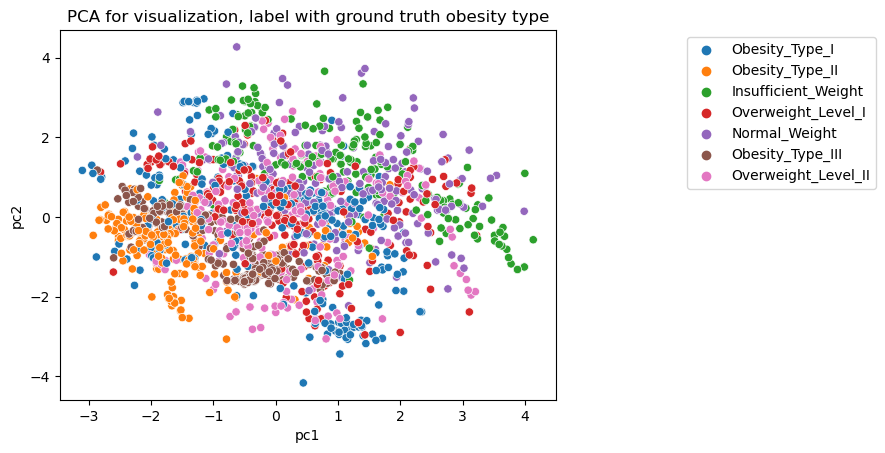

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

# call fit_transform on pca
pcs = pca.fit_transform(X_train)

# transform it into data frame
pcs = pd.DataFrame(pcs,columns=['pc1','pc2'])
pcs.index = X_train.index
# plot the components
pcs['obesity_type'] = y_train

sns.scatterplot(data=pcs, x='pc1', y='pc2', hue='obesity_type')
plt.title('PCA for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1))

PCA gives us a nice overview of what's happening, although there is significant overlap between the different types of obesity, plus there's not much separation between categories. Let's keep experimenting with UMAP and observe our results.

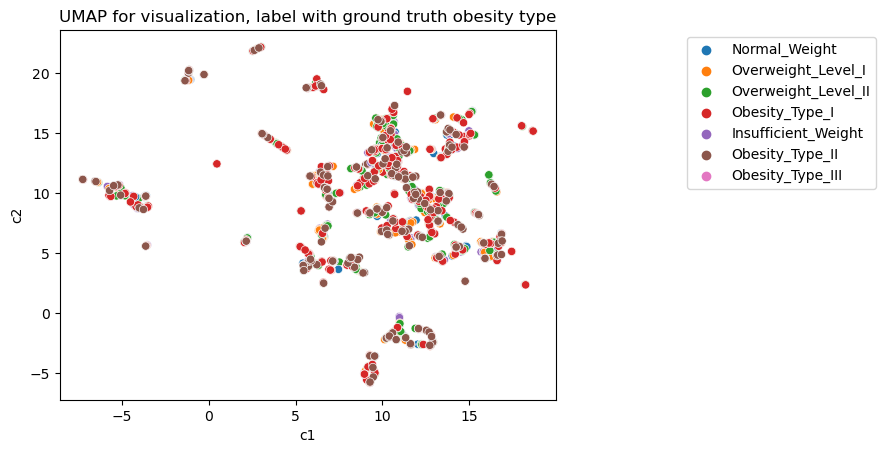

In [16]:
viz = UMAP(n_neighbors=5, min_dist=0.1)
viz_coords = pd.DataFrame(viz.fit_transform(X_train), columns=['c1', 'c2'])
viz_coords['obesity_type'] = obesity_labels

sns.scatterplot(data=viz_coords, x='c1', y='c2', hue='obesity_type')
plt.title('UMAP for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1))

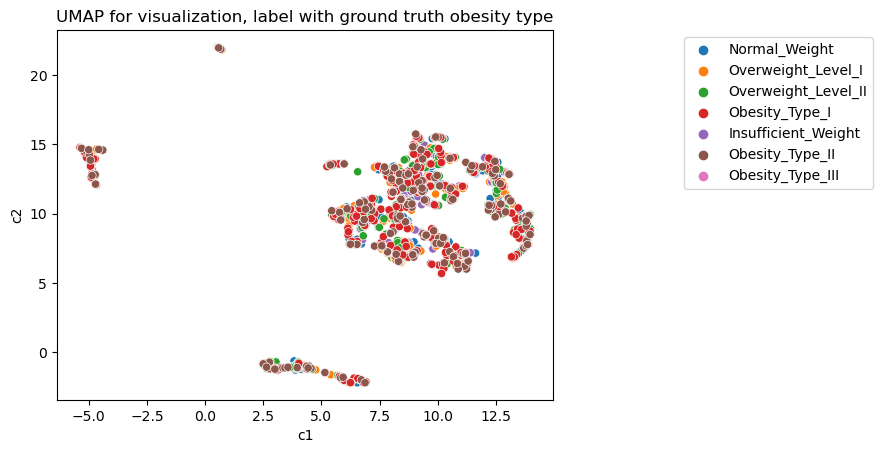

In [17]:
viz = UMAP(n_neighbors=20, min_dist=0.1)
viz_coords = pd.DataFrame(viz.fit_transform(X_train), columns=['c1', 'c2'])
viz_coords['obesity_type'] = obesity_labels

sns.scatterplot(data=viz_coords, x='c1', y='c2', hue='obesity_type')
plt.title('UMAP for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1))

## UMAP results
We sampled just two values of n_neighbors due to the sake of scope and computational complexity, but we can see that the data is tightly centered with little coherence in both cases. Obesity_Type_III appears to have a distinct separability from the rest of the labels, generally with a high degree of covariance. Let's try tSNE to see if we can get a a better picture of the data

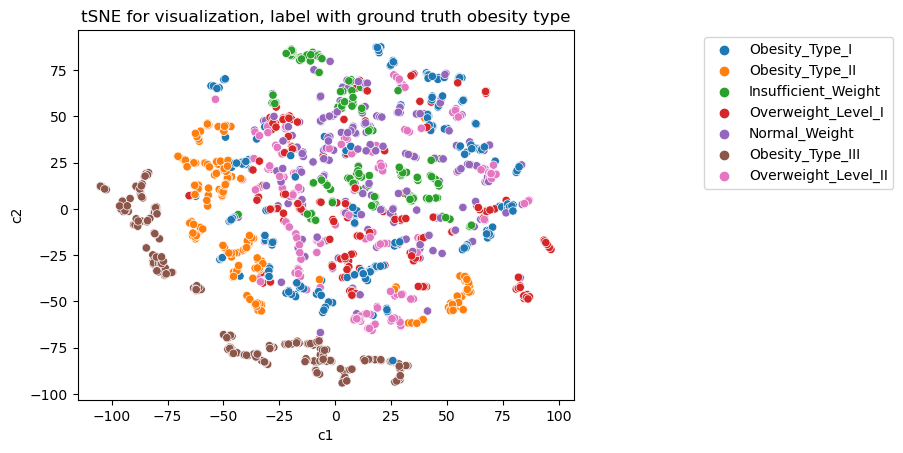

In [18]:
tsne_perp_5 = TSNE(n_components = 2, perplexity = 5, random_state = 99)
tcs = tsne_perp_5.fit_transform(X_train)
# construct the data frame
tcs = pd.DataFrame(tcs,columns=['c1','c2'])
tcs.index = X_train.index

tcs['obesity_type'] = y_train

sns.scatterplot(data=tcs, x='c1', y='c2', hue='obesity_type')
plt.title('tSNE for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1));



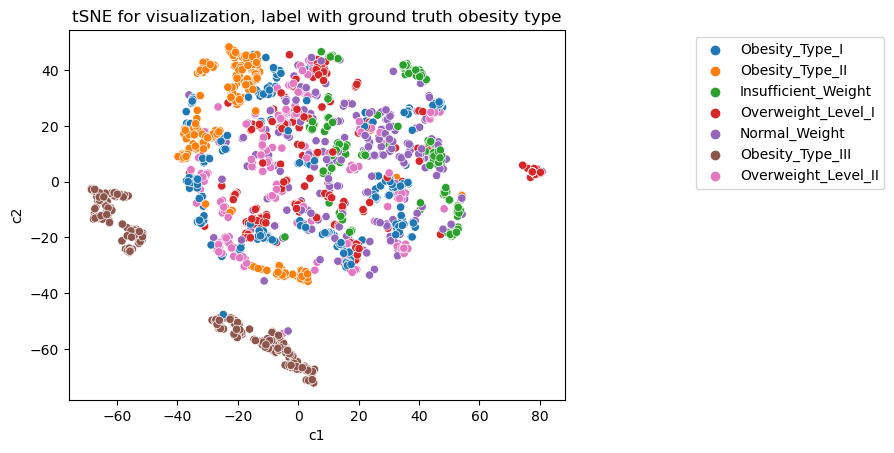

In [19]:
tsne_perp_20 = TSNE(n_components = 2, perplexity = 20, random_state = 99)
tcs = tsne_perp_20.fit_transform(X_train)
# construct the data frame
tcs = pd.DataFrame(tcs,columns=['c1','c2'])
tcs.index = X_train.index

tcs['obesity_type'] = y_train

sns.scatterplot(data=tcs, x='c1', y='c2', hue='obesity_type')
plt.title('tSNE for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1))



## tSNE Results
tSNE captures the local relationships so we do we see somewhat better results however at least in 2 dimensions, the data doesn't seem to adhere to the assumptions of classical models like KMeans nor GMM. Something like DBSCAN, Spectral, or Hierarchical clustering might offer a solution. We can try running KMeans as a baseline measure. Before moving on, we should first decide on an optimal perplexity parameter going forward to maintain consistent plots. We'll fine tune it  using the KL divergence as a performance metric

In [20]:
perplexities= [2, 5, 10, 20, 40, 80, 100, 200, 400]
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import gaussian_kde
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
# Define range of perplexity values
REPS = 10  # Number of random starts

# Initialize arrays to store results
costs = []
all_perplexities = []

# Perform t-SNE for each perplexity value
for perplexity in perplexities:
        # Uses barnes hut approximation to speed up process
        tsne = TSNE(n_components=2, perplexity=perplexity, method='barnes_hut', n_iter=1000, random_state=99)
        embedded_data = tsne.fit_transform(X_train)

        # Compute KL divergence
        kl_divergence = tsne.kl_divergence_

        # Store KL divergence and perplexity
        costs.append(kl_divergence)


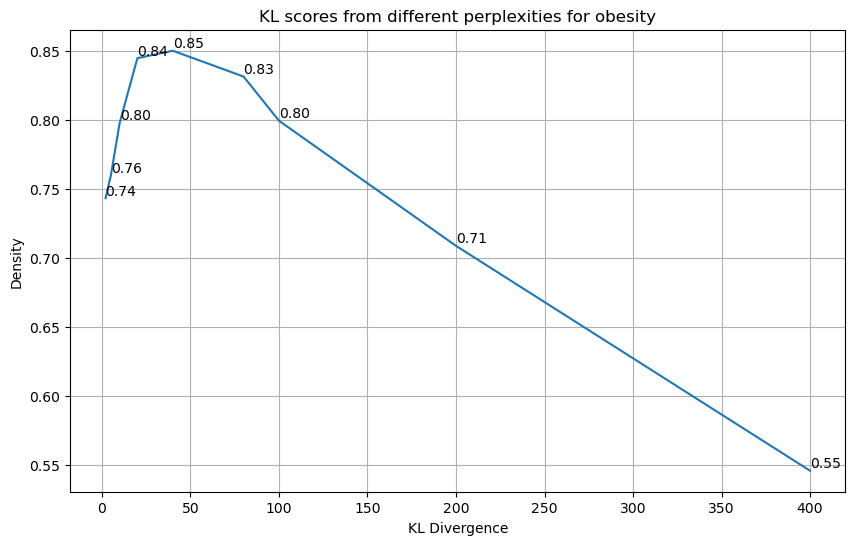

In [21]:
plt.figure(figsize=(10, 6))  # Set width to 10 inches and height to 6 inches

plt.plot(perplexities, costs)

plt.title('KL scores from different perplexities for obesity')
plt.xlabel('KL Divergence')
plt.ylabel('Density')  # Add ylabel for the y-axis

for i, (perplexity, cost) in enumerate(zip(perplexities, costs)):
    plt.text(perplexity, cost, f'{cost:.2f}', verticalalignment='bottom')

plt.grid()
plt.show()

We can see that a perplexity value of 20 does as good a job. To keep things simple, we'll stick with 20.

### Determining the number of clusters for the KMeans

By using the kneelocator, we are able to plot the graph for a range of clusters, and visually see where the fall off of clusters takes place.

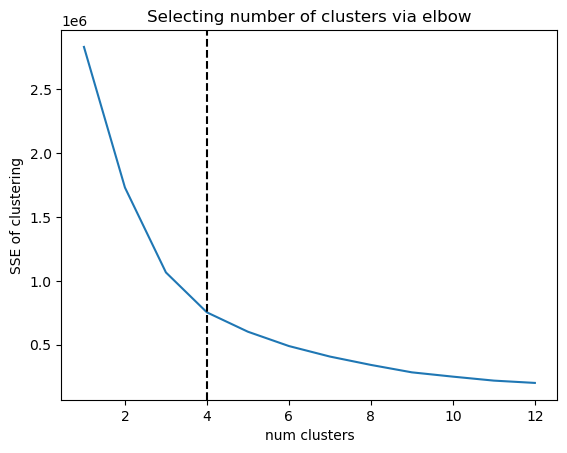

In [22]:
import sklearn.cluster as cluster
from kneed import KneeLocator

tsne = TSNE(n_components=2, perplexity=20, method='barnes_hut', n_iter=1000, random_state=99)
tcs = tsne.fit_transform(X_train)
tcs = pd.DataFrame(tcs,columns=['c1','c2'])
tcs.index = X_train.index
sse=[]

maxk = 13
for k in range(1,maxk):
    clust = cluster.KMeans(n_clusters=k)
    clust.fit(tcs)
    sse.append(clust.inertia_)

# finds the location of max curvature
location = KneeLocator(range(1,maxk), sse, S=1.0, curve="convex", direction="decreasing")

plt.plot(range(1,maxk),sse)
plt.axvline(location.elbow, color="black", linestyle="--")

plt.xlabel('num clusters')
plt.ylabel('SSE of clustering')
plt.title('Selecting number of clusters via elbow');

Using this number of 4, we will create silhouette analyses for a range around the number of clusters determined by the elbow for a better visual representation of the clusters. (NOTE: will changed the plot from UMAP to tSNE)

# Kmeans on original training data with silhouette analysis

For n_clusters = 3 The average silhouette_score is : 0.13207179068299552
For n_clusters = 4 The average silhouette_score is : 0.13441112943936803
For n_clusters = 5 The average silhouette_score is : 0.12438982810054641


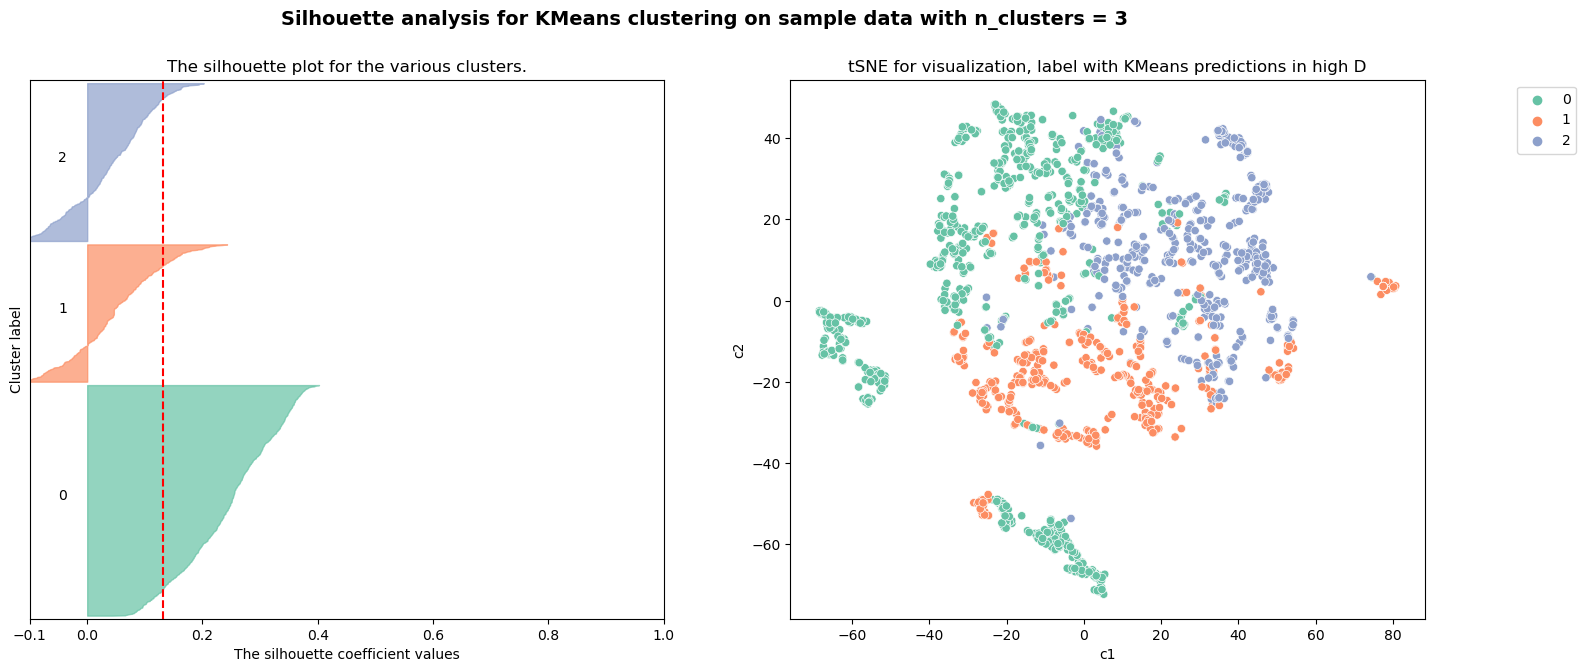

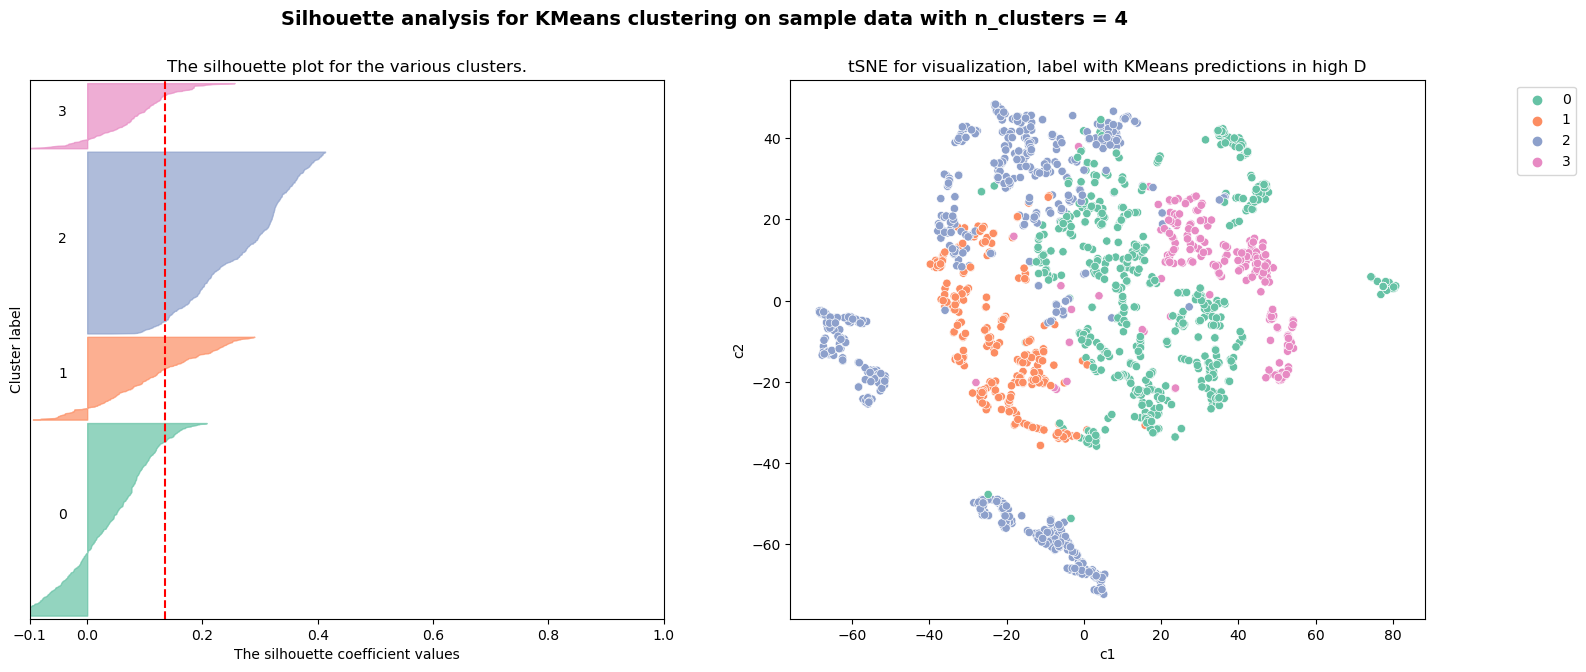

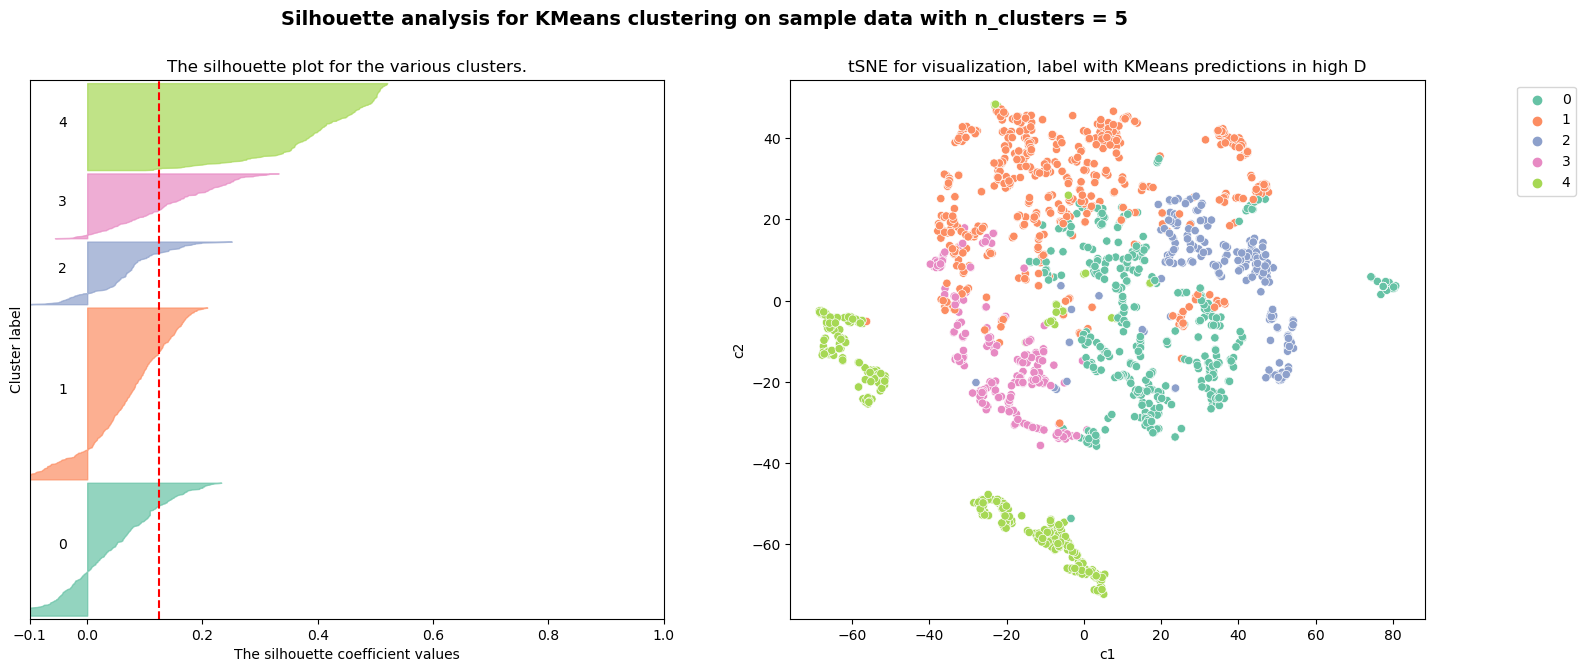

In [23]:
##copy/pasted from lecture notebook 19 and edited to be used for our data
### copy/pasted with some mods from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

X= X_train.values #turn into numpy

range_n_clusters = [3, 4, 5] #Determined by the elbow above

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = sns.color_palette('Set2', n_clusters)[i]
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    
    predicted = clusterer.predict(X)
    tcs['prediction'] = predicted
    sns.scatterplot(data=tcs, x='c1', y='c2', hue='prediction', 
                    palette='Set2', ax=ax2)
    plt.title('tSNE for visualization, label with KMeans predictions in high D')
    ax2.legend(bbox_to_anchor=(1.25, 1));

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Looking at the silhouettes, it is easy to determine that clustering via KMeans is not what we should pursue for this data, which adheres to our previous findings with the t-SNE.This is because the shapes of the silhouettes are not similar enough with each other in all three of the plots for us to reason using a KMeans clustering. Next, we will try a DBSCAN to better cluster our data.

## K Nearest Neighbors

Next, we want to understand the local density of the data after fitting and transforming our data with T-SNE. We can use the Nearest Neighbors model to showcase how close points are to each other. By determining the distance of the elbow, we can use that data as a starting point for our eps value when creating our DBSCAN.

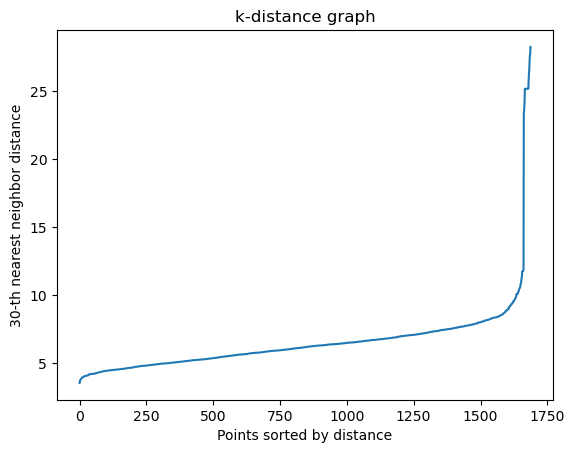

In [36]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=20, method='barnes_hut', n_iter=1000, random_state=99)
tcs = tsne.fit_transform(X_train)

# Compute the distances to kth nearest neighbors
k = 30  # You may need to adjust this value based on your data
nbrs = NearestNeighbors(n_neighbors=k).fit(tcs)
distances, _ = nbrs.kneighbors(tcs)
distances = np.sort(distances[:, -1])

# Plot the sorted distances
plt.plot(distances)
plt.title('k-distance graph')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.show()


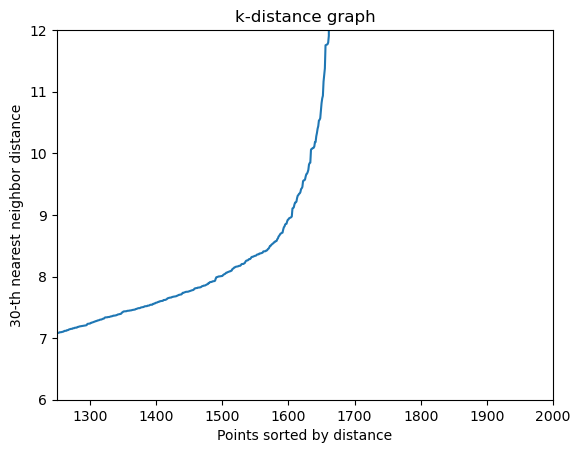

In [29]:
# # Zooming in of the elbow
# plt.plot(distances)
# plt.title('k-distance graph')
# plt.xlabel('Points sorted by distance')
# plt.ylabel(f'{k}-th nearest neighbor distance')

# # Zoom in by setting x-axis limits
# plt.xlim([1250, 2000])  # Adjust the limits based on your data
# plt.ylim([6, 12])  # Adjust the limits based on your data

# plt.show()

Looking at the elbow above, we can see that distance increases sharply after around 8. We played around with the numbers and saw that at k=65, the elbow was at 12. What we decided to do was test out all of them. Since we were trying to determine our eps value, we used the range between the 2 plus a little padding for our DBSCAN.

## DBSCAN after transforming training data to low D

In [41]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score


best_score = -1
best_params = None

for eps in [8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5]:  # Example values for eps
    for min_samples in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]:  # Example values for min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(tcs)
        dbscan_labels = dbscan.labels_
        
        # Compute adjusted Rand index

        score = adjusted_rand_score(y_train, dbscan_labels)
        print(f"eps={eps}, min_samples={min_samples}, Adjusted Rand Index: {score}")

        # Update best score and parameters
        if score > best_score:
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples}

print("Best parameters:", best_params)
print("Best Adjusted Rand Index:", best_score)




eps=8, min_samples=10, Adjusted Rand Index: 0.08343665355518369
eps=8, min_samples=20, Adjusted Rand Index: 0.08343665355518369
eps=8, min_samples=30, Adjusted Rand Index: 0.0890063825033255
eps=8, min_samples=40, Adjusted Rand Index: 0.12079160170715868
eps=8, min_samples=50, Adjusted Rand Index: 0.0884165377041458
eps=8, min_samples=60, Adjusted Rand Index: 0.05612981179700055
eps=8, min_samples=70, Adjusted Rand Index: 0.031898818175923827
eps=8, min_samples=80, Adjusted Rand Index: 0.0
eps=8, min_samples=90, Adjusted Rand Index: 0.0
eps=8, min_samples=100, Adjusted Rand Index: 0.0
eps=8, min_samples=110, Adjusted Rand Index: 0.0
eps=8, min_samples=120, Adjusted Rand Index: 0.0
eps=8, min_samples=130, Adjusted Rand Index: 0.0
eps=8, min_samples=140, Adjusted Rand Index: 0.0
eps=8, min_samples=150, Adjusted Rand Index: 0.0
eps=8.5, min_samples=10, Adjusted Rand Index: 0.08343665355518369
eps=8.5, min_samples=20, Adjusted Rand Index: 0.08343665355518369
eps=8.5, min_samples=30, Adjust

The best Adjusted Rand Index is low at 0.127, but it is higher than 0, which means there is slight agreement. What we found surprising was that the best parameters was eps = 13 and min_samples = 120. This is because in the Nearest Neighbors plot above, we saw the elbow at 8 with our k at 30, so these DBSCANS found a better hyperparameters that resulted in a higher ARI score. However, if we look at the print statements above, we can see that eps=8 and min_neighbors = 40, which is slightly more than our k = 30, gave a relatively comparable ARI, so we decided to use those values instead.

### Plotting our DBSCAN with optimal hyperparameters

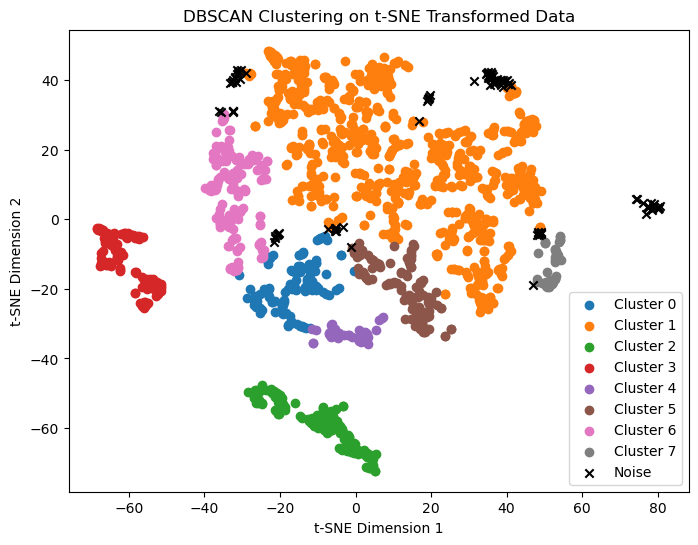

In [43]:
from sklearn.cluster import DBSCAN
# Apply DBSCAN on the transformed data
dbscan = DBSCAN(eps=8, min_samples=40)
dbscan.fit(tcs)

# Extract cluster labels
cluster_labels = dbscan.labels_

# Number of clusters (ignore noise, represented by -1)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

# Plot the clusters
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(tcs[cluster_labels == i][:, 0], tcs[cluster_labels == i][:, 1], label=f'Cluster {i}')
plt.scatter(tcs[cluster_labels == -1][:, 0], tcs[cluster_labels == -1][:, 1], color='black', marker='x', label='Noise')
plt.title('DBSCAN Clustering on t-SNE Transformed Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

In [331]:
# #try number 2
# # Instantiate the DBSCAN model with the best parameters
# dbscan = DBSCAN(eps=13, min_samples=120)

# # Train the DBSCAN model on the training data
# trained = dbscan.fit(tcs)

# # Obtain the cluster labels assigned by DBSCAN
# cluster_labels = trained.labels_

# ari = adjusted_rand_score(y_train, cluster_labels)
# print(ari)
# #for some reason ari is 0. I printed cluster_labels and its an array of 0s but not sure why

### Building our pipeline to train models

In order to actually train our data, we need to create a pipeline to streamline our workflow, ensuring consistency when reproducing it. However, because we used TSNE for our dimension reduction, we needed to create classes for TSNE and DBSCAN that could transform and fit our data.

In [44]:
#try number 1
##apparently tsne doesnt work for training cause it doesnt have a transform and fit method??

# ^ resolved: just make a class

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification

class TestTSNE(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.n_components = 2
        self.method = 'barnes_hut'
        self.n_iter = 1000
        self.random_state = 99
        self.perplexity = 20

    def fit(self, X, y = None):
        ts = TSNE(n_components = self.n_components, perplexity = self.perplexity, method = self.method, n_iter = self.n_iter, random_state = self.random_state)
        self.embedding_ = ts.fit_transform(X)
        return self

    def transform(self, X, y = None):
        return X
    
    
class DBSCANTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.eps = 13
        self.min_samples = 100

    def fit(self, X, y=None):
        self.dbscan_ = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        self.dbscan_.fit(X)
        return self

    def transform(self, X):
        return np.column_stack([X, self.dbscan_.labels_])
    
    def predict(self, X):
        return self.dbscan_.fit_predict(X)
    
scaler = StandardScaler()
knn = KNeighborsClassifier(n_neighbors=20)

pipe = Pipeline([
    ('tsne', TestTSNE()),
#     ('scaler', scaler),  # Scale the data after dimensionality reduction
    ('dbscan', DBSCANTransformer()),
#     ('knn', knn) # adding knn in the pipeline would perform another classification which is not what we want
])


# if you want to make a pipeline for knn, make a new one

pipe.fit(X_train, y_train)

Pipeline(steps=[('tsne', TestTSNE()), ('dbscan', DBSCANTransformer())])

We can plot our training set by the true label to see how the difference between our clusters created by the DBSCAN and the actual labels.

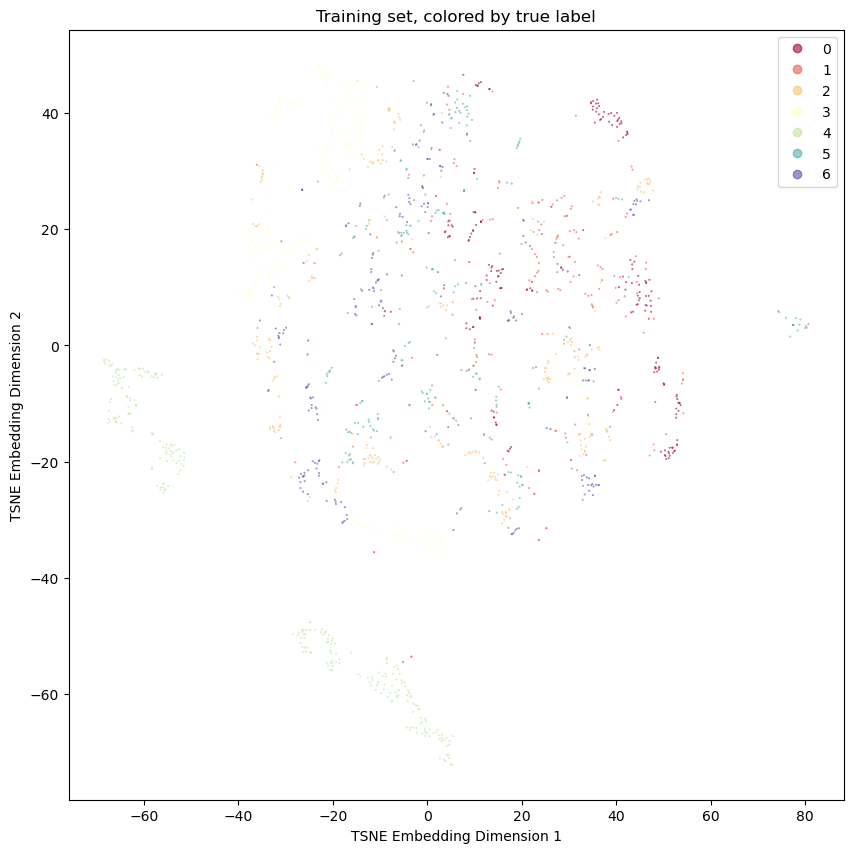

In [45]:
from sklearn.preprocessing import LabelEncoder

embedding_train = pipe.steps[0][1].embedding_
label_encoder = LabelEncoder()

# Encode categorical labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=y_train_encoded.astype(int), s=0.1, cmap='Spectral')
handles, _ = scatter.legend_elements(prop="colors", alpha=0.6) # use my own labels
legend1 = plt.legend(handles, np.arange(0, 10))
plt.title('Train set, colored by prediction')
plt.title('Training set, colored by true label')
plt.xlabel("TSNE Embedding Dimension 1")
plt.ylabel("TSNE Embedding Dimension 2")

We can see that the clusters in the outer portions of the data are relatively similar to the clusters of the DBSCAN, but most of the inner clustering of the DBSCAN is off.

In [46]:
prediction = pipe.predict(X_test)
y_test_encoded = label_encoder.fit_transform(y_test)
prediction_encoded = label_encoder.fit_transform(prediction)
print(classification_report(y_test_encoded, prediction_encoded))

              precision    recall  f1-score   support

           0       0.15      1.00      0.27        65
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00        53
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00        57
           6       0.00      0.00      0.00        55

    accuracy                           0.15       423
   macro avg       0.02      0.14      0.04       423
weighted avg       0.02      0.15      0.04       423



When running the prediction, we see that the accuracy of our model is quite low at 15%. This makes sense because for the most part, our DBSCAN clustered most of the middle points together, which would be incorrect, but the outer edges clustered properly.